In [1]:
import shutil
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import os 
import sys
import matplotlib.pyplot as plt
import pandas as pd
from pyDOE import lhs
%load_ext autoreload
%autoreload 2

In [2]:
sys.path.append('../scripts/')

In [3]:
import bayesiangp

In [4]:
import functools

In [5]:
# Generate synthetic data
inputs = np.arange(2,20,0.5)
outputs = np.square(inputs) + 10*np.random.randn(len(inputs))

test_inputs = np.array([3.4,7.7, 8.5, 11.6, 13.7, 15.1, 19.3])

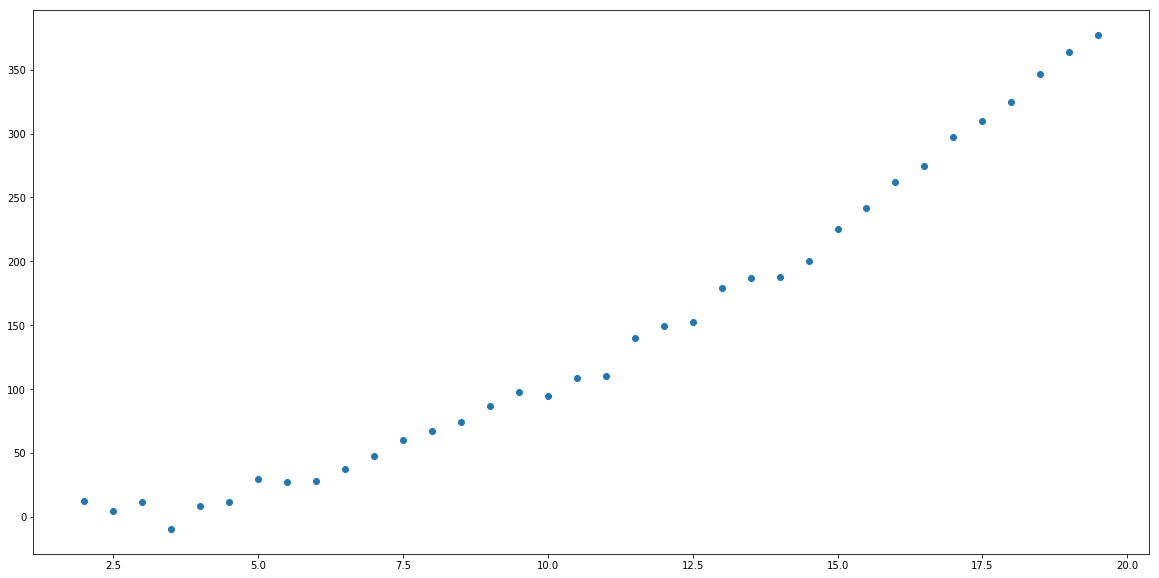

In [6]:
plt.figure(figsize =(20,10))
plt.scatter(inputs,outputs)

In [7]:
labels = ['x']

In [8]:
# Normalizing the outputs 
mean = np.mean(outputs)
std = np.std(outputs)
outputsnorm = (outputs - mean)/std

In [9]:
# normalizing the inputs
mean_x = np.mean(inputs, axis = 0)
std_x = np.std(inputs, axis = 0, keepdims = True)

inputsnorm = (inputs - mean_x)/std_x
test_inputsnorm = (test_inputs - mean_x)/std_x

scaling_inp = [mean_x, std_x]

In [10]:
model = bayesiangp.BayesianGP(inputsnorm, outputsnorm, 'RBF', 1e-3)


In [11]:
n_inputs = 1

In [12]:
# Initializing the hyperparameters
beta = 1.5*tf.ones(n_inputs, tf.float32)
varm = 0.8
loc = 0.0


initial_state = [beta, varm, loc]

In [13]:
num_leapfrog_steps = 3
mcmc_samples = 4000
num_warmup_iters = 3000
em_iters = 1000

In [14]:
loc_probs_, varm_probs_, beta_probs_, acceptance_rate_, loss_history,_ = model.EM_with_MCMC(initial_state, num_warmup_iters, em_iters, mcmc_samples, num_leapfrog_steps, learning_rate = 0.05)

Warm-up phase.
Warm-Up Iteration:   0 Acceptance Rate: 1.000
Warm-Up Iteration: 200 Acceptance Rate: 0.622
Warm-Up Iteration: 400 Acceptance Rate: 0.608
Warm-Up Iteration: 600 Acceptance Rate: 0.591
Warm-Up Iteration: 800 Acceptance Rate: 0.589
Warm-Up Iteration: 1000 Acceptance Rate: 0.596
Warm-Up Iteration: 1200 Acceptance Rate: 0.585
Warm-Up Iteration: 1400 Acceptance Rate: 0.582
Warm-Up Iteration: 1600 Acceptance Rate: 0.578
Warm-Up Iteration: 1800 Acceptance Rate: 0.573
Warm-Up Iteration: 2000 Acceptance Rate: 0.572
Warm-Up Iteration: 2200 Acceptance Rate: 0.570
Warm-Up Iteration: 2400 Acceptance Rate: 0.571
Warm-Up Iteration: 2600 Acceptance Rate: 0.570
Warm-Up Iteration: 2800 Acceptance Rate: 0.571
Warm-Up Iteration: 2999 Acceptance Rate: 0.569
Estimating the noise variance: 
Iteration:    0 Loss: -19.088
Iteration:  200 Loss: -33.632
Iteration:  400 Loss: -32.938
Iteration:  600 Loss: -33.927
Iteration:  800 Loss: -31.706
Iteration:  999 Loss: -34.962
Acceptance rate of the HMC

In [15]:
print(loc_probs_.shape)

(4000,)


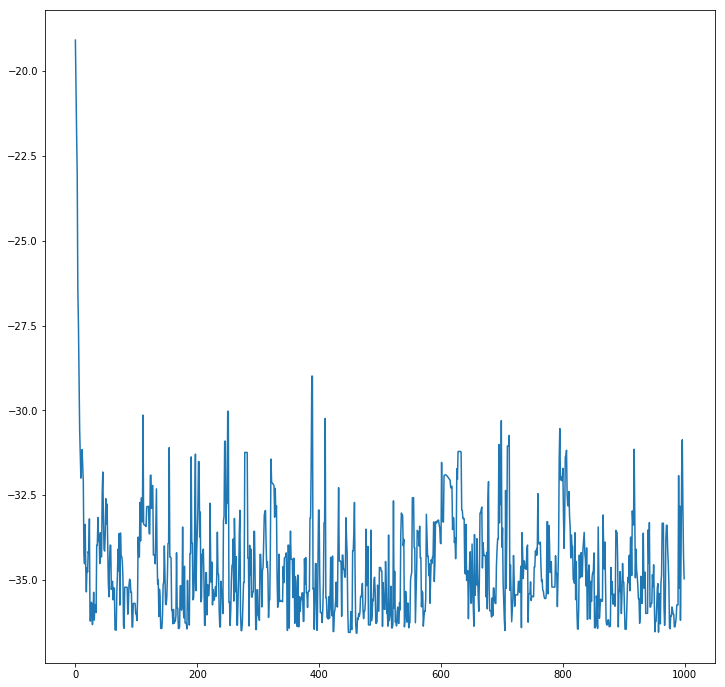

In [16]:
plt.figure(figsize=(12,12))
plt.plot(loss_history)

In [17]:
results_path = '../results/toy_example/'

In [18]:
# Plotting and saving the chains for the inverse lengthscale 
t = np.arange(mcmc_samples)
for i in range(n_inputs):
    plt.figure(figsize = (20,10))
    plt.plot(t,beta_probs_[:,i])
    title = 'Beta_for_' +  labels[i]
    plt.title(title)
    figpath = results_path + 'mcmc_chains/' + title + '.png'
    plt.savefig(figpath)
    plt.close()

    
# Plotting and saving the chains for the variances  
plt.figure(figsize = (20,10))
plt.plot(t,varm_probs_)
title = 'variance'
plt.title(title)
figpath = results_path + 'mcmc_chains/' + title + '.png'
plt.savefig(figpath)
plt.close()



# Plotting and saving the chains for the constant mean function
plt.figure(figsize = (20,10))
plt.plot(t,loc_probs_[:])
title = 'constant_mean'
plt.title(title)
figpath = results_path + 'mcmc_chains/' + title + '.png'
plt.savefig(figpath)
plt.close()

In [19]:
print(loc_probs_.shape)
print(varm_probs_.shape)
print(beta_probs_.shape)

(4000,)
(4000,)
(4000, 1)


In [20]:
hyperpar_samples = [loc_probs_, varm_probs_, beta_probs_]

In [21]:
# Generating prediction for test data
mean_pos, var_pos, samples = model.samples(inputsnorm, hyperpar_samples, num_samples = 20, with_point_samples = True)
mean_test, var_test, samples_test = model.samples(test_inputsnorm , hyperpar_samples, num_samples = 20, with_point_samples = True)


In [22]:
print(mean_pos.shape)
print(var_pos.shape)
print(samples.shape)

print(mean_test.shape)
print(var_test.shape)
print(samples_test.shape)

(36,)
(36,)
(80000, 36)
(7,)
(7,)
(80000, 7)


In [23]:
std_pos = np.sqrt(var_pos)
std_test = np.sqrt(var_test)

In [24]:
# Converting to the right scale
mean_posf = mean_pos*std + mean 
std_posf = std_pos*std 
samplesf = samples*std + mean

mean_testf = mean_test*std + mean 
std_testf = std_test*std 
samples_testf = samples_test*std + mean

In [25]:
lower = np.percentile(samplesf,2.5, axis = 0)
upper = np.percentile(samplesf,97.5, axis = 0)

lower_test = np.percentile(samples_testf,2.5, axis = 0)
upper_test = np.percentile(samples_testf,97.5, axis = 0)

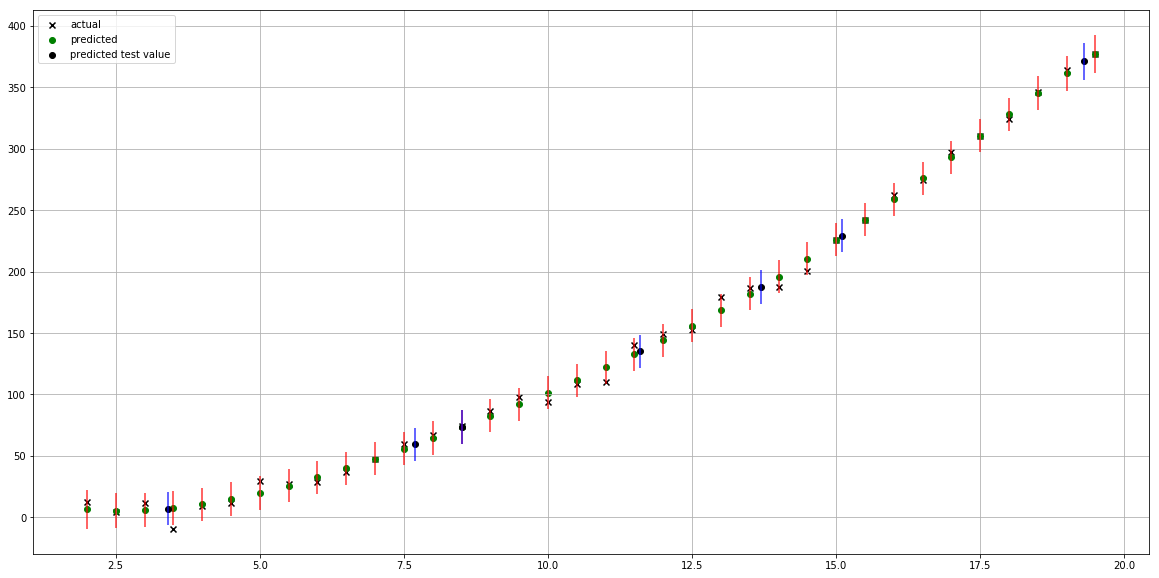

In [26]:
if n_inputs == 1:
    plt.figure(figsize =(20,10))
    plt.scatter(inputs,outputs,marker='x', color = 'black', label = 'actual')
    plt.scatter(inputs, mean_posf, color = 'green', label = 'predicted')
    plt.vlines(inputs, lower, upper, color = 'red', alpha = 0.8)
    
    plt.scatter(test_inputs,mean_testf,marker='o', color = 'black', label = 'predicted test value')
    plt.vlines(test_inputs, lower_test, upper_test, color = 'blue', alpha = 0.8)
    figpath = results_path + 'predictions.png'
    plt.grid()
    plt.legend()
    plt.savefig(figpath)
#     plt.close()
    
   

In [27]:
print(model.noise)

0.0030875243


In [30]:
# saving the data 
df = pd.DataFrame()
df['x'] = inputs
df['y'] = outputs
print(df.head())
df.to_csv('../tests/training_data.csv', index = False)

     x          y
0  2.0  12.741655
1  2.5   4.577834
2  3.0  11.752015
3  3.5  -9.572530
4  4.0   8.871737
